In [1]:


import pandas as pd
import json

file_path = "SavedCustomTreeMets/The100/_bipedal/trees/FalseBaselineFD0.json"

# Path to the CSV file
csv_file_path = 'output_folder_tmp/_bipedalnormTrue/X7.csv'

# Load the CSV into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame to ensure it's loaded correctly
print(df.keys())
with open(file_path, 'r') as file:
    tree = json.load(file)

def forward_pass(tree, row):
    if "Value" in tree:
        # We've hit a leaf node
        return tree["Value"]
    
    feature = tree["Feature"]
    bucket = tree["Bucket"]
    
    # Determine whether to go left (True) or right (False)
    if row[feature] < bucket:
        return forward_pass(tree["Left_Child"], row)
    else:
        return forward_pass(tree["Right_Child"], row)

# Example usage:
# Assuming 'df' is your pandas DataFrame and 'tree' is your decision tree stored as a dictionary
print(tree)
row = df.iloc[0]  # Forward pass for the first row of the DataFrame
output = forward_pass(tree, row)
print("Output:", output)


Index(['Hull Angle', 'Hull Angular Velocity', 'Velocity X', 'Velocity Y',
       'Hip Joint 1 Angle', 'Hip Joint 1 Speed', 'Knee Joint 1 Angle',
       'Knee Joint 1 Speed', 'Leg 1 Ground Contact Flag', 'Hip Joint 2 Angle',
       'Hip Joint 2 Speed', 'Knee Joint 2 Angle', 'Knee Joint 2 Speed',
       'Leg 2 Ground Contact Flag', 'Lidar Sensor 1', 'Lidar Sensor 2',
       'Lidar Sensor 3', 'Lidar Sensor 4', 'Lidar Sensor 5', 'Lidar Sensor 6',
       'Lidar Sensor 7', 'Lidar Sensor 8', 'Lidar Sensor 9',
       'Lidar Sensor 10'],
      dtype='object')
{'Feature': 'Hip Joint 1 Speed', 'Bucket': -0.74805796, 'Left_Child': {'Feature': 'Knee Joint 1 Angle', 'Bucket': -0.183450875, 'Left_Child': {'Feature': 'Knee Joint 2 Angle', 'Bucket': 0.241051495, 'Left_Child': {'Feature': 'Knee Joint 1 Angle', 'Bucket': -0.421480115, 'Left_Child': {'Feature': 'Hull Angle', 'Bucket': 0.0759050135, 'Left_Child': {'Value': [-2.8114698, 4.918441, 2.0384564, 2.215083]}, 'Right_Child': {'Feature': 'Hull Angle

In [2]:
def forward_pass_with_path(tree, row, path=[]):
    if "Value" in tree:
        return tree["Value"], path
    
    feature = tree["Feature"]
    bucket = tree["Bucket"]
    
    if row[feature] < bucket:
        path.append((feature, "left", bucket))
        return forward_pass_with_path(tree["Left_Child"], row, path)
    else:
        path.append((feature, "right", bucket))
        return forward_pass_with_path(tree["Right_Child"], row, path)

# Get the forward pass and path for the first row
output, path = forward_pass_with_path(tree, df.iloc[0])
print("Output:", output)
print("Path:", path)

def generate_counterfactual(path, row, output, desired_output):
    # Adjust the feature values to affect the first output in the list
    for feature, direction, bucket in reversed(path):
        if direction == "left" and output[0] > desired_output:
            # If we went left, we need to increase the feature to decrease the output
            print(f"Increase {feature} (currently {row[feature]}) closer to or above {bucket} to reduce output")
            row[feature] = bucket + 0.01  # Adjust to go to the other side of the bucket
        elif direction == "right" and output[0] > desired_output:
            # If we went right, we need to decrease the feature to decrease the output
            print(f"Decrease {feature} (currently {row[feature]}) closer to or below {bucket} to reduce output")
            row[feature] = bucket - 0.01  # Adjust to go to the other side of the bucket

    # After adjustments, run forward pass again to check if output decreases
    print("row:",row)
    new_output = forward_pass(tree, row)
    out1, path2 = forward_pass_with_path(tree, row)
    print("Path:", path2)
    return new_output

# Example usage: Decrease the first output to a lower value
desired_output = output[0] - 0.5  # Let's say we want to decrease the first output by 0.5
counterfactual_output = generate_counterfactual(path, df.iloc[0].copy(), output, desired_output)

print("Counterfactual Output:", counterfactual_output)

Output: [2.6001236, -1.5604547, 1.0964583, -1.066551]
Path: [('Hip Joint 1 Speed', 'right', -0.74805796), ('Knee Joint 1 Angle', 'right', -0.5408116000000001), ('Knee Joint 2 Speed', 'left', -0.77611512), ('Velocity Y', 'right', 0.0713097045), ('Velocity X', 'right', 0.51900153), ('Hull Angle', 'right', 0.0334703525)]
Decrease Hull Angle (currently 0.058673933) closer to or below 0.0334703525 to reduce output
Decrease Velocity X (currently 0.52160466) closer to or below 0.51900153 to reduce output
Decrease Velocity Y (currently 0.07328747) closer to or below 0.0713097045 to reduce output
Increase Knee Joint 2 Speed (currently -0.87377787) closer to or above -0.77611512 to reduce output
Decrease Knee Joint 1 Angle (currently -0.30762947) closer to or below -0.5408116000000001 to reduce output
Decrease Hip Joint 1 Speed (currently 0.9991208) closer to or below -0.74805796 to reduce output
row: Hull Angle                   0.023470
Hull Angular Velocity        0.030113
Velocity X         

In [3]:
from graphviz import Digraph

def visualize_tree(tree, graph=None, parent=None, edge_label=""):
    if graph is None:
        graph = Digraph()

    # Base case: if it's a leaf node, add the leaf value
    if "Value" in tree:
        node_label = f"Leaf\n{tree['Value']}"
        graph.node(str(id(tree)), label=node_label)
        if parent is not None:
            graph.edge(parent, str(id(tree)), label=edge_label)
        return graph

    # Create a node for the current feature and bucket
    node_label = f"{tree['Feature']} < {tree['Bucket']}"
    graph.node(str(id(tree)), label=node_label)

    # If this node has a parent, connect them
    if parent is not None:
        graph.edge(parent, str(id(tree)), label=edge_label)

    # Recursively create the left and right children
    if "Left_Child" in tree:
        visualize_tree(tree["Left_Child"], graph, str(id(tree)), "True (Left)")
    
    if "Right_Child" in tree:
        visualize_tree(tree["Right_Child"], graph, str(id(tree)), "False (Right)")

    return graph

# Example usage: visualize your decision tree
graph = visualize_tree(tree)
graph.render("decision_tree_VIZ", format="png", cleanup=True)  # Saves as decision_tree.png

'decision_tree_VIZ.png'

In [17]:
def reverse_query_with_counterfactual(tree, path, current_output, target_output):
    """
    Searches for a counterfactual by traversing parents and siblings of the current path.
    Returns the first counterfactual output that satisfies the target condition.
    """
    # Step 1: Traverse the path in reverse to check parents
    for i in range(len(path) - 1, -1, -1):
        feature, direction, bucket = path[i]

        # Step 2: Find the parent node; stop if we encounter a leaf node
        parent_node = find_parent_node(tree, path[:i])
        if "Value" in parent_node:
            continue  # Skip leaf nodes, no further traversal possible

        # Step 3: Find the sibling output (opposite child of the current direction)
        sibling_output = forward_pass_with_alternate_branch(parent_node, path[i], path[i + 1:])
        
        # Step 4: Check if sibling output is less than the current output (for counterfactual)
        if sibling_output and sibling_output[0] < current_output[0]:
            print(f"Counterfactual found at parent node: {parent_node}, output: {sibling_output}")
            return sibling_output
    
    return None  # No suitable counterfactual found

def find_parent_node(tree, partial_path):
    """
    Follows the partial path in the tree and returns the parent node just before the last node in the path.
    Stops if it encounters a leaf node.
    """
    current_node = tree
    for feature, direction, bucket in partial_path:
        if "Value" in current_node:
            break  # Stop if we've reached a leaf node
        if direction == "left":
            current_node = current_node["Left_Child"]
        else:
            current_node = current_node["Right_Child"]
    return current_node

def forward_pass_with_alternate_branch(tree, current_step, remaining_path):
    """
    Performs a forward pass starting from the alternate branch (sibling) of the current node.
    """
    feature, direction, bucket = current_step
    
    # If the current node is a leaf, we can't proceed further
    if "Value" in tree:
        return None

    # If the current direction was 'left', go to the right sibling, and vice versa
    if direction == "left":
        alternate_branch = tree["Right_Child"]
    else:
        alternate_branch = tree["Left_Child"]

    # Now perform a forward pass through the sibling node
    return forward_pass(alternate_branch, remaining_path)

# Example usage:
print(df.iloc[1])
output, path = forward_pass_with_path(tree, df.iloc[1])  # Get output and path from forward pass
print(output)
target_output = output[1] - 0.5  # Target a reduction in the first output value
counterfactual = reverse_query_with_counterfactual(tree, path, output, target_output)

if counterfactual:
    print("Counterfactual found:", counterfactual)
else:
    print("No suitable counterfactual found.")

Hull Angle                  -0.068457
Hull Angular Velocity        0.021721
Velocity X                   0.574168
Velocity Y                   0.002751
Hip Joint 1 Angle            0.109261
Hip Joint 1 Speed            1.000000
Knee Joint 1 Angle          -0.593351
Knee Joint 1 Speed           0.000000
Leg 1 Ground Contact Flag    0.000000
Hip Joint 2 Angle            1.134113
Hip Joint 2 Speed            0.000000
Knee Joint 2 Angle           0.064916
Knee Joint 2 Speed           0.235588
Leg 2 Ground Contact Flag    0.000000
Lidar Sensor 1               0.332643
Lidar Sensor 2               0.340483
Lidar Sensor 3               0.365046
Lidar Sensor 4               0.403739
Lidar Sensor 5               0.456878
Lidar Sensor 6               0.529613
Lidar Sensor 7               0.633720
Lidar Sensor 8               0.777456
Lidar Sensor 9               0.994870
Lidar Sensor 10              1.000000
Name: 1, dtype: float64
[1.9177824, 0.8780499, 0.13545468, -0.49847338]


TypeError: list indices must be integers or slices, not str

{'Feature': 'Hip Joint 1 Speed', 'Bucket': -0.74805796, 'Left_Child': {'Feature': 'Knee Joint 1 Angle', 'Bucket': -0.183450875, 'Left_Child': {'Feature': 'Knee Joint 2 Angle', 'Bucket': 0.241051495, 'Left_Child': {'Feature': 'Knee Joint 1 Angle', 'Bucket': -0.421480115, 'Left_Child': {'Feature': 'Hull Angle', 'Bucket': 0.0759050135, 'Left_Child': {'Value': [-2.8114698, 4.918441, 2.0384564, 2.215083]}, 'Right_Child': {'Feature': 'Hull Angle', 'Bucket': 0.142067895, 'Left_Child': {'Feature': 'Hull Angle', 'Bucket': 0.1281945, 'Left_Child': {'Feature': 'Hull Angle', 'Bucket': 0.108314685, 'Left_Child': {'Value': [-1.2257447, 5.2543063, 0.71335995, 0.2700503]}, 'Right_Child': {'Value': [-1.6216501, 4.990268, 0.92828655, 0.49831194]}}, 'Right_Child': {'Value': [-0.7444564, 5.660722, 0.77971447, 0.5146489]}}, 'Right_Child': {'Feature': 'Hull Angular Velocity', 'Bucket': 0.00514001805, 'Left_Child': {'Feature': 'Hull Angle', 'Bucket': 0.19094041, 'Left_Child': {'Value': [-1.2330716, 4.892232,

In [39]:
def find_closest_path(tree, target_output, desired_change, initial_path):
    """
    Performs a reverse tree search starting from the node specified by `initial_path` to find a leaf node that 
    matches the criteria.
    Args:
        tree (dict): The decision tree represented as nested dictionaries.
        target_output (list): The current output at the specified node.
        desired_change (tuple): (index, change) - which element of the output should be changed and by how much.
        initial_path (list): A list representing the path taken to reach the starting node. Each element is a tuple 
                             (feature, direction, bucket).
    Returns:
        list: The path to the closest leaf node that matches the criteria.
    """
    index, change = desired_change
    visited = set()

    def recursive_search(node, path):
        """
        Recursive search function to explore siblings, parent siblings, etc., for a matching leaf node.
        """
        if id(node) in visited:
            return None
        visited.add(id(node))

        # If it's a leaf node, check if it matches the criteria
        if "Value" in node:
            if node["Value"][index] < target_output[index] + change:
                return path
            else:
                return None

        # Search siblings if they exist
        if len(path) > 0:
            parent_node = find_parent_node(tree, path[:-1])
            current_direction = path[-1][1]
            sibling_direction = "right" if current_direction == "left" else "left"
            sibling_node = parent_node.get(f"{sibling_direction.capitalize()}_Child")
            if sibling_node:
                sibling_path = path[:-1] + [(path[-1][0], sibling_direction, path[-1][2])]
                result = recursive_search(sibling_node, sibling_path)
                if result:
                    return result

        # Continue searching the parent's siblings
        if len(path) > 1:
            grandparent_node = find_parent_node(tree, path[:-2])
            parent_direction = path[-2][1]
            parent_sibling_direction = "right" if parent_direction == "left" else "left"
            parent_sibling_node = grandparent_node.get(f"{parent_sibling_direction.capitalize()}_Child")
            if parent_sibling_node:
                parent_sibling_path = path[:-2] + [(path[-2][0], parent_sibling_direction, path[-2][2])]
                result = recursive_search(parent_sibling_node, parent_sibling_path)
                if result:
                    return result

        # Move up to grandparent and continue search if no match was found in siblings
        if len(path) > 2:
            return recursive_search(tree, path[:-2])

        return None

    return recursive_search(tree, initial_path)

def find_initial_path_and_output(tree, row):
    """
    Traverses the tree using the given row to find the initial path and output.
    Args:
        tree (dict): The decision tree represented as nested dictionaries.
        row (pd.Series): A pandas Series representing a single row of data.
    Returns:
        tuple: (initial_path, output) where initial_path is the path to the leaf node, and output is the value at the leaf node.
    """
    path = []
    current_node = tree

    while "Value" not in current_node:
        feature = current_node["Feature"]
        bucket = current_node["Bucket"]
        if row[feature] < bucket:
            path.append((feature, "left", bucket))
            current_node = current_node["Left_Child"]
        else:
            path.append((feature, "right", bucket))
            current_node = current_node["Right_Child"]

    return path, current_node["Value"]

# Find initial path and output
row = df.iloc[1]
initial_path, output = find_initial_path_and_output(tree, row)
print("Initial path:", initial_path)
print("Output:", output)

# Desired change: decrease output[0]
closest_path = find_closest_path(tree, output, (1, 0.1), initial_path)

print("Closest path:", closest_path)  # Output path that matches the criteria
if closest_path:
    closest_node = find_parent_node(tree, closest_path)
    print("Closest path output:", closest_node.get("Value"))

Initial path: [('Hip Joint 1 Speed', 'right', -0.74805796), ('Knee Joint 1 Angle', 'left', -0.5408116000000001), ('Knee Joint 2 Speed', 'right', -0.41077512), ('Hull Angular Velocity', 'right', -0.0109037791), ('Hip Joint 1 Angle', 'left', 0.17982605499999998), ('Knee Joint 2 Angle', 'right', -0.054426133), ('Hull Angle', 'left', 0.117103958)]
Output: [1.9177824, 0.8780499, 0.13545468, -0.49847338]
Closest path: None


In [45]:
def find_closest_path(tree, target_output, desired_change, initial_path):
    """
    Performs a reverse tree search starting from the node specified by `initial_path` to find a leaf node that 
    matches the criteria.
    Args:
        tree (dict): The decision tree represented as nested dictionaries.
        target_output (list): The current output at the specified node.
        desired_change (tuple): (index, change) - which element of the output should be changed and by how much.
        initial_path (list): A list representing the path taken to reach the starting node. Each element is a tuple 
                             (feature, direction, bucket).
    Returns:
        list: The path to the closest leaf node that matches the criteria.
    """
    index, change = desired_change
    visited = set()
    queue = [(initial_path, find_parent_node(tree, initial_path))]

    while queue:
        path, node = queue.pop(0)

        if id(node) in visited:
            continue
        visited.add(id(node))

        # If it's a leaf node, check if it matches the criteria
        if "Value" in node:
            if node["Value"][index] < target_output[index] + change and node["Value"] != target_output:
                return path

        # Add sibling nodes to the queue
        if len(path) > 0:
            parent_node = find_parent_node(tree, path[:-1])
            current_direction = path[-1][1]
            sibling_direction = "right" if current_direction == "left" else "left"
            sibling_node = parent_node.get(f"{sibling_direction.capitalize()}_Child")
            if sibling_node:
                sibling_path = path[:-1] + [(path[-1][0], sibling_direction, path[-1][2])]
                queue.append((sibling_path, sibling_node))

        # Add parent nodes to the queue to continue searching upwards
        if len(path) > 1:
            parent_path = path[:-1]
            parent_node = find_parent_node(tree, parent_path)
            if parent_node and "Value" not in parent_node:
                queue.append((parent_path, parent_node))

            # Add parent's sibling nodes to the queue
            grandparent_node = find_parent_node(tree, path[:-2]) if len(path) > 2 else None
            if grandparent_node:
                parent_direction = path[-2][1]
                parent_sibling_direction = "right" if parent_direction == "left" else "left"
                parent_sibling_node = grandparent_node.get(f"{parent_sibling_direction.capitalize()}_Child")
                if parent_sibling_node and parent_sibling_node != parent_node:
                    parent_sibling_path = path[:-2] + [(path[-2][0], parent_sibling_direction, path[-2][2])]
                    queue.append((parent_sibling_path, parent_sibling_node))

    return None

def find_initial_path_and_output(tree, row):
    """
    Traverses the tree using the given row to find the initial path and output.
    Args:
        tree (dict): The decision tree represented as nested dictionaries.
        row (pd.Series): A pandas Series representing a single row of data.
    Returns:
        tuple: (initial_path, output) where initial_path is the path to the leaf node, and output is the value at the leaf node.
    """
    path = []
    current_node = tree

    while "Value" not in current_node:
        feature = current_node["Feature"]
        bucket = current_node["Bucket"]
        if row[feature] < bucket:
            path.append((feature, "left", bucket))
            current_node = current_node["Left_Child"]
        else:
            path.append((feature, "right", bucket))
            current_node = current_node["Right_Child"]

    return path, current_node["Value"]
# Find initial path and output
row = df.iloc[1]
initial_path, output = find_initial_path_and_output(tree, row)
print("Initial path:", initial_path)
print("Output:", output)

# Desired change: decrease output[0]
closest_path = find_closest_path(tree, output, (1, 0.1), initial_path)

print("Closest path:", closest_path)  # Output path that matches the criteria
if closest_path:
    closest_node = find_parent_node(tree, closest_path)
    print("Closest path output:", closest_node.get("Value"))

Initial path: [('Hip Joint 1 Speed', 'right', -0.74805796), ('Knee Joint 1 Angle', 'left', -0.5408116000000001), ('Knee Joint 2 Speed', 'right', -0.41077512), ('Hull Angular Velocity', 'right', -0.0109037791), ('Hip Joint 1 Angle', 'left', 0.17982605499999998), ('Knee Joint 2 Angle', 'right', -0.054426133), ('Hull Angle', 'left', 0.117103958)]
Output: [1.9177824, 0.8780499, 0.13545468, -0.49847338]
Closest path: None


In [48]:
def find_closest_path(tree, target_output, desired_change, initial_path):
    """
    Performs a reverse tree search starting from the node specified by `initial_path` to find a leaf node that 
    matches the criteria.
    Args:
        tree (dict): The decision tree represented as nested dictionaries.
        target_output (list): The current output at the specified node.
        desired_change (tuple): (index, change) - which element of the output should be changed and by how much.
        initial_path (list): A list representing the path taken to reach the starting node. Each element is a tuple 
                             (feature, direction, bucket).
    Returns:
        list: The path to the closest leaf node that matches the criteria.
    """
    index, change = desired_change
    visited = set()
    queue = [(initial_path, find_parent_node(tree, initial_path))]
    best_path = None

    while queue:
        path, node = queue.pop(0)

        if id(node) in visited:
            continue
        visited.add(id(node))

        # If it's a leaf node, check if it matches the criteria
        if "Value" in node:
            if node["Value"][index] < target_output[index] + change and node["Value"] != target_output:
                if best_path is None or abs(node["Value"][index] - (target_output[index] + change)) < abs(best_path["Value"][index] - (target_output[index] + change)):
                    best_path = (path, node)

        # Add sibling nodes to the queue
        if len(path) > 0:
            parent_node = find_parent_node(tree, path[:-1])
            current_direction = path[-1][1]
            sibling_direction = "right" if current_direction == "left" else "left"
            sibling_node = parent_node.get(f"{sibling_direction.capitalize()}_Child")
            if sibling_node and sibling_node != node:
                sibling_path = path[:-1] + [(path[-1][0], sibling_direction, path[-1][2])]
                queue.append((sibling_path, sibling_node))

        # Add parent nodes to the queue to continue searching upwards
        if len(path) > 1:
            parent_path = path[:-1]
            parent_node = find_parent_node(tree, parent_path)
            if parent_node and "Value" not in parent_node:
                queue.append((parent_path, parent_node))

            # Add parent's sibling nodes to the queue
            grandparent_node = find_parent_node(tree, path[:-2]) if len(path) > 2 else None
            if grandparent_node:
                parent_direction = path[-2][1]
                parent_sibling_direction = "right" if parent_direction == "left" else "left"
                parent_sibling_node = grandparent_node.get(f"{parent_sibling_direction.capitalize()}_Child")
                if parent_sibling_node and parent_sibling_node != parent_node:
                    parent_sibling_path = path[:-2] + [(path[-2][0], parent_sibling_direction, path[-2][2])]
                    queue.append((parent_sibling_path, parent_sibling_node))

    if best_path:
        return best_path[0]
    return None

def find_initial_path_and_output(tree, row):
    """
    Traverses the tree using the given row to find the initial path and output.
    Args:
        tree (dict): The decision tree represented as nested dictionaries.
        row (pd.Series): A pandas Series representing a single row of data.
    Returns:
        tuple: (initial_path, output) where initial_path is the path to the leaf node, and output is the value at the leaf node.
    """
    path = []
    current_node = tree

    while "Value" not in current_node:
        feature = current_node["Feature"]
        bucket = current_node["Bucket"]
        if row[feature] < bucket:
            path.append((feature, "left", bucket))
            current_node = current_node["Left_Child"]
        else:
            path.append((feature, "right", bucket))
            current_node = current_node["Right_Child"]

    return path, current_node["Value"]



# Create a sample row for querying
row = df.iloc[1]
initial_path, output = find_initial_path_and_output(tree, row)
print("Initial path:", initial_path)
print("Output:", output)

# Desired change: decrease output[0]
closest_path = find_closest_path(tree, output, (1, 0.1), initial_path)

print("Closest path:", closest_path)  # Output path that matches the criteria
if closest_path:
    closest_node = find_parent_node(tree, closest_path)
    print("Closest path output:", closest_node.get("Value"))

Initial path: [('Hip Joint 1 Speed', 'right', -0.74805796), ('Knee Joint 1 Angle', 'left', -0.5408116000000001), ('Knee Joint 2 Speed', 'right', -0.41077512), ('Hull Angular Velocity', 'right', -0.0109037791), ('Hip Joint 1 Angle', 'left', 0.17982605499999998), ('Knee Joint 2 Angle', 'right', -0.054426133), ('Hull Angle', 'left', 0.117103958)]
Output: [1.9177824, 0.8780499, 0.13545468, -0.49847338]
Closest path: None


In [73]:
def find_path_for_input(tree, row):
    """
    Traverses the tree using the given row to find the path to the leaf node.
    Args:
        tree (dict): The decision tree represented as nested dictionaries.
        row (pd.Series): A pandas Series representing a single row of data.
    Returns:
        tuple: A tuple containing the output value at the leaf node and a list of tuples representing the path to the leaf node.
    """
    path = []
    current_node = tree

    while "Value" not in current_node:
        feature = current_node["Feature"]
        bucket = current_node["Bucket"]
        if row[feature] < bucket:
            path.append((feature, "left", bucket))
            current_node = current_node["Left_Child"]
        else:
            path.append((feature, "right", bucket))
            current_node = current_node["Right_Child"]

    return current_node["Value"], path

def find_all_matching_nodes(tree, index, threshold):
    """
    Performs a complete search of the tree to find all nodes where the value at the specified index is smaller than the threshold.
    Args:
        tree (dict): The decision tree represented as nested dictionaries.
        index (int): The index of the value to compare.
        threshold (float): The threshold value.
    Returns:
        list: A list of paths, where each path is a list of tuples representing the path to a matching leaf node.
    """
    matching_nodes = []

    def recursive_search(node, path):
        # If it's a leaf node, check if it matches the condition
        if "Value" in node:
            if node["Value"][index] < threshold:
                matching_nodes.append((node["Value"], path))
            return

        # Recurse on left child
        if "Left_Child" in node:
            feature = node["Feature"]
            bucket = node["Bucket"]
            left_path = path + [(feature, "left", bucket)]
            recursive_search(node["Left_Child"], left_path)

        # Recurse on right child
        if "Right_Child" in node:
            feature = node["Feature"]
            bucket = node["Bucket"]
            right_path = path + [(feature, "right", bucket)]
            recursive_search(node["Right_Child"], right_path)

    # Start the recursive search from the root of the tree
    recursive_search(tree, [])
    return matching_nodes


# def sort_paths_by_similarity(matching_paths, example_path):
#     """
#     Sorts the list of matching paths such that paths with fewer equal tuples to the example path are earlier in the list,
#     and paths with more equal tuples are later.
#     Args:
#         matching_paths (list): A list of paths, where each path is a list of tuples representing a path to a leaf node.
#         example_path (list): A list of tuples representing the example path to compare to.
#     Returns:
#         list: The sorted list of paths.
#     """
#     def similarity_score(path1, path2):
#         """
#         Calculates the similarity score between two paths based on the number of equal tuples.
#         Args:
#             path1 (list): The first path.
#             path2 (list): The second path.
#         Returns:
#             int: The similarity score (higher means more similar).
#         """
#         common_length = min(len(path1), len(path2))
#         return sum(1 for i in range(common_length) if path1[i] == path2[i])

#     sorted_paths = sorted(matching_paths, key=lambda p: similarity_score(p, example_path))
#     return sorted_paths

def sort_paths_by_similarity(matching_paths, example_path):
    """
    Sorts the list of matching paths such that paths with fewer equal tuples to the example path are earlier in the list,
    and paths with more equal tuples are later. The output value is maintained with the path.
    Args:
        matching_paths (list): A list of tuples, where each tuple contains the output value and the path to a leaf node.
        example_path (list): A list of tuples representing the example path to compare to.
    Returns:
        list: The sorted list of tuples containing the output value and the path.
    """
    def similarity_score(path1, path2):
        """
        Calculates the similarity score between two paths based on the number of equal tuples.
        Args:
            path1 (list): The first path.
            path2 (list): The second path.
        Returns:
            int: The similarity score (higher means more similar).
        """
        common_length = min(len(path1), len(path2))
        return sum(1 for i in range(common_length) if path1[i] == path2[i])

    sorted_paths = sorted(matching_paths, key=lambda p: similarity_score(p[1], example_path))
    return sorted_paths
# Example Usage:
import pandas as pd
row = df.iloc[0]
output, path = find_path_for_input(tree, row)
print("Output for input:", output)
print("Path for input:", path)
index = 1
threshold = output[index]
matching_paths = find_all_matching_nodes(tree, index=index, threshold=threshold)
MP = [path for _, path in matching_paths]
sorted_paths = sort_paths_by_similarity(matching_paths, path)
print("Sorted paths by similarity:")
# for sorted_path in sorted_paths:
#     print(sorted_path)
out, counterpath = sorted_paths[-1]
print(counterpath)
print(path)

print(output, out)


Output for input: [2.6001236, -1.5604547, 1.0964583, -1.066551]
Path for input: [('Hip Joint 1 Speed', 'right', -0.74805796), ('Knee Joint 1 Angle', 'right', -0.5408116000000001), ('Knee Joint 2 Speed', 'left', -0.77611512), ('Velocity Y', 'right', 0.0713097045), ('Velocity X', 'right', 0.51900153), ('Hull Angle', 'right', 0.0334703525)]
Sorted paths by similarity:
[('Hip Joint 1 Speed', 'right', -0.74805796), ('Knee Joint 1 Angle', 'right', -0.5408116000000001), ('Knee Joint 2 Speed', 'right', -0.77611512), ('Hull Angular Velocity', 'left', 0.0006162398), ('Hull Angle', 'left', 0.147862875), ('Velocity X', 'right', 0.6477166249999999), ('Hull Angle', 'left', 0.055649731)]
[('Hip Joint 1 Speed', 'right', -0.74805796), ('Knee Joint 1 Angle', 'right', -0.5408116000000001), ('Knee Joint 2 Speed', 'left', -0.77611512), ('Velocity Y', 'right', 0.0713097045), ('Velocity X', 'right', 0.51900153), ('Hull Angle', 'right', 0.0334703525)]
[2.6001236, -1.5604547, 1.0964583, -1.066551] [1.8289393, 

In [74]:

def find_differences_between_paths(path1, path2):
    """
    Finds the nodes that are different between two given paths.
    Args:
        path1 (list): The first path, represented as a list of tuples.
        path2 (list): The second path, represented as a list of tuples.
    Returns:
        list: A list of tuples representing the nodes that are different between the two paths.
    """
    differences = []
    common_length = min(len(path1), len(path2))

    # Compare nodes up to the common length
    for i in range(common_length):
        if path1[i] != path2[i]:
            differences.append((path1[i], path2[i]))

    # Add remaining nodes from the longer path
    if len(path1) > len(path2):
        differences.extend([(node, None) for node in path1[common_length:]])
    elif len(path2) > len(path1):
        differences.extend([(None, node) for node in path2[common_length:]])

    return differences
print(find_differences_between_paths(path, counterpath))

[(('Knee Joint 2 Speed', 'left', -0.77611512), ('Knee Joint 2 Speed', 'right', -0.77611512)), (('Velocity Y', 'right', 0.0713097045), ('Hull Angular Velocity', 'left', 0.0006162398)), (('Velocity X', 'right', 0.51900153), ('Hull Angle', 'left', 0.147862875)), (('Hull Angle', 'right', 0.0334703525), ('Velocity X', 'right', 0.6477166249999999)), (None, ('Hull Angle', 'left', 0.055649731))]


In [76]:
def find_first_non_equal_node_and_count(path1, path2):
    """
    Finds the first non-equal node between two paths and counts how many nodes after are also not equal.
    Args:
        path1 (list): The first path, represented as a list of tuples.
        path2 (list): The second path, represented as a list of tuples.
    Returns:
        tuple: A tuple containing the first non-equal node (as a pair from both paths) and the count of non-equal nodes after it.
    """
    common_length = min(len(path1), len(path2))
    first_non_equal = None
    non_equal_count = 0
    found_first = False

    # Compare nodes up to the common length
    for i in range(common_length):
        if path1[i] != path2[i]:
            if not found_first:
                first_non_equal = (path1[i], path2[i])
                found_first = True
            non_equal_count += 1

    # Count remaining nodes from the longer path
    if len(path1) > len(path2):
        if not found_first and len(path1) > common_length:
            first_non_equal = (path1[common_length], None)
        non_equal_count += len(path1) - common_length
    elif len(path2) > len(path1):
        if not found_first and len(path2) > common_length:
            first_non_equal = (None, path2[common_length])
        non_equal_count += len(path2) - common_length

    return first_non_equal, non_equal_count
first_non_equal, non_equal_count = find_first_non_equal_node_and_count(path, counterpath)

In [78]:
first_non_equal[1]

('Knee Joint 2 Speed', 'right', -0.77611512)

In [79]:
non_equal_count

5

In [94]:
row = df.iloc[0]
feature_Baseline = []
for i in range(0,100):
    file_path = f"SavedCustomTreeMets/The100/_bipedal/trees/FalseBaselineFD{i}.json"


    # Display the first few rows of the DataFrame to ensure it's loaded correctly
    #print(df.keys())
    with open(file_path, 'r') as file:
        tree = json.load(file)

    output, path = find_path_for_input(tree, row)
    #print("Output for input:", output)
    #print("Path for input:", path)
    index = 0
    threshold = output[0]
    matching_paths = find_all_matching_nodes(tree, index=index, threshold=threshold)
    MP = [path for _, path in matching_paths]
    sorted_paths = sort_paths_by_similarity(matching_paths, path)
    #print("Sorted paths by similarity:")
    # for sorted_path in sorted_paths:
    #     print(sorted_path)
    out, counterpath = sorted_paths[-1]
    first_non_equal, non_equal_count = find_first_non_equal_node_and_count(path, counterpath)
    feature_Baseline.append(first_non_equal[1][0])

feature_Var = []
for i in range(0,100):
    file_path = f"SavedCustomTreeMets/The100/_bipedal/trees/FalseVar_weightedLRP{i}.json"


    # Display the first few rows of the DataFrame to ensure it's loaded correctly
    #print(df.keys())
    with open(file_path, 'r') as file:
        tree = json.load(file)

    output, path = find_path_for_input(tree, row)
    #print("Output for input:", output)
    #print("Path for input:", path)
    index = 0
    threshold = output[0]
    matching_paths = find_all_matching_nodes(tree, index=index, threshold=threshold)
    MP = [path for _, path in matching_paths]
    sorted_paths = sort_paths_by_similarity(matching_paths, path)
    #print("Sorted paths by similarity:")
    # for sorted_path in sorted_paths:
    #     print(sorted_path)
    out, counterpath = sorted_paths[-1]
    first_non_equal, non_equal_count = find_first_non_equal_node_and_count(path, counterpath)
    feature_Var.append(first_non_equal[1][0])
    
    
feature_all = []
for i in range(0,100):
    file_path = f"SavedCustomTreeMets/The100/_bipedal/trees/FalseMax_allLRP{i}.json"


    # Display the first few rows of the DataFrame to ensure it's loaded correctly
    #print(df.keys())
    with open(file_path, 'r') as file:
        tree = json.load(file)

    output, path = find_path_for_input(tree, row)
    #print("Output for input:", output)
    #print("Path for input:", path)
    index = 0
    threshold = output[0]
    matching_paths = find_all_matching_nodes(tree, index=index, threshold=threshold)
    MP = [path for _, path in matching_paths]
    sorted_paths = sort_paths_by_similarity(matching_paths, path)
    #print("Sorted paths by similarity:")
    # for sorted_path in sorted_paths:
    #     print(sorted_path)
    out, counterpath = sorted_paths[-1]
    first_non_equal, non_equal_count = find_first_non_equal_node_and_count(path, counterpath)
    feature_all.append(first_non_equal[1][0])

feature_avg = []
for i in range(0,100):
    file_path = f"SavedCustomTreeMets/The100/_bipedal/trees/FalseMax_avgLRP{i}.json"


    # Display the first few rows of the DataFrame to ensure it's loaded correctly
    #print(df.keys())
    with open(file_path, 'r') as file:
        tree = json.load(file)

    output, path = find_path_for_input(tree, row)
    #print("Output for input:", output)
    #print("Path for input:", path)
    index = 0
    threshold = output[0]
    matching_paths = find_all_matching_nodes(tree, index=index, threshold=threshold)
    MP = [path for _, path in matching_paths]
    sorted_paths = sort_paths_by_similarity(matching_paths, path)
    #print("Sorted paths by similarity:")
    # for sorted_path in sorted_paths:
    #     print(sorted_path)
    out, counterpath = sorted_paths[-1]
    first_non_equal, non_equal_count = find_first_non_equal_node_and_count(path, counterpath)
    feature_avg.append(first_non_equal[1][0])

FileNotFoundError: [Errno 2] No such file or directory: 'SavedCustomTreeMets/The100/_bipedal/trees/FalseVar_weightedLRP2.json'

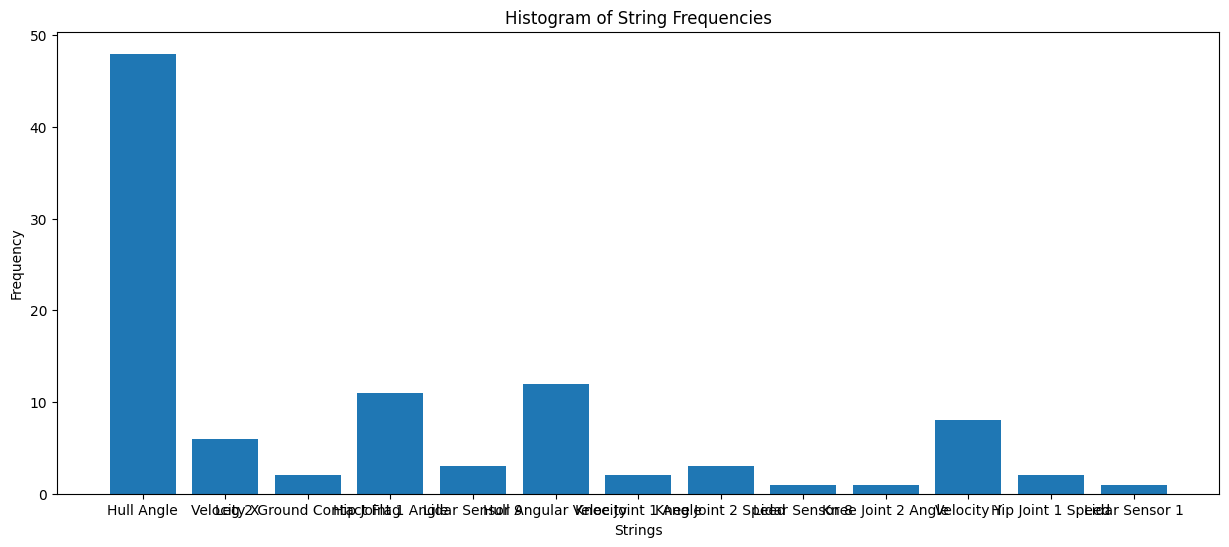

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

string_list = feature
string_counts = Counter(string_list)

# Create the histogram
plt.figure(figsize=(15, 6))
plt.bar(string_counts.keys(), string_counts.values())

#plt.figure(figsize=(15, 6))
# Add labels and title
plt.xlabel('Strings')
plt.ylabel('Frequency')
plt.title('Histogram of String Frequencies')

# Display the plot
plt.show()

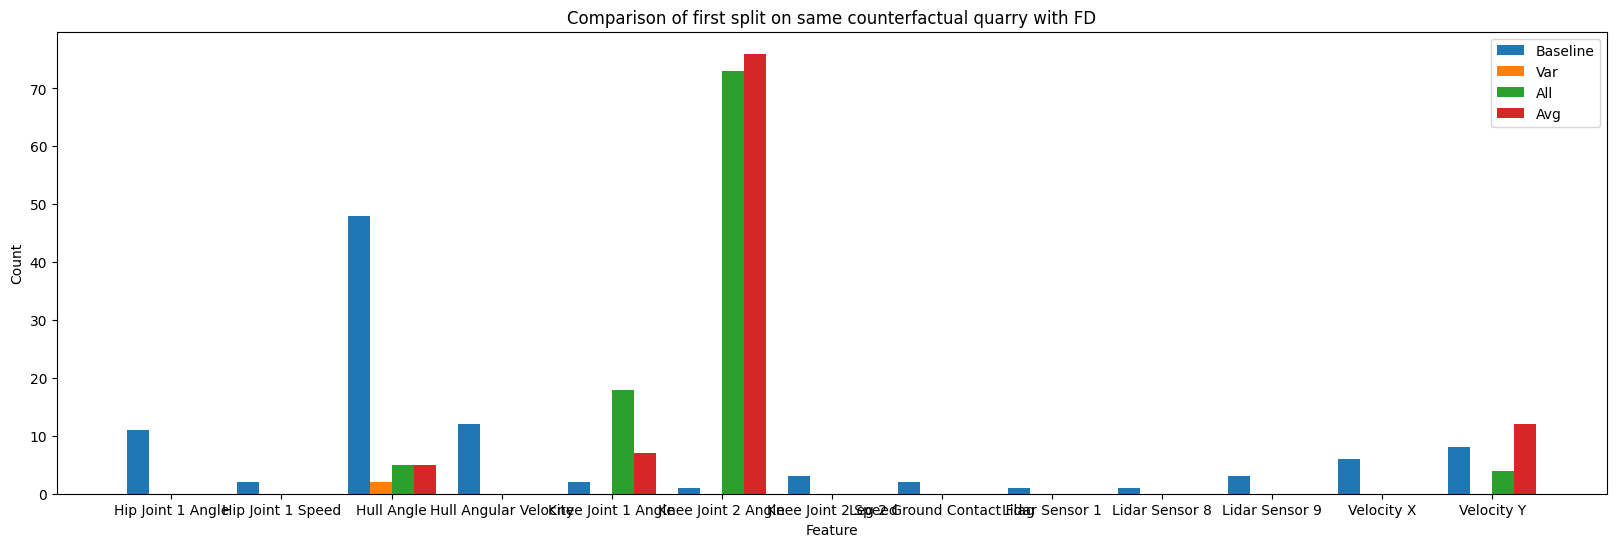

In [96]:
counter1 = Counter(feature_Baseline)
counter2 = Counter(feature_Var)
counter3 = Counter(feature_all)
counter4 = Counter(feature_avg)

# Combine all unique strings from all lists to have a common x-axis
all_strings = sorted(set(counter1.keys()) | set(counter2.keys()) | set(counter3.keys()) | set(counter4.keys()))

# Create an array of positions for the x-axis
x = np.arange(len(all_strings))

# Width of each bar
bar_width = 0.2
plt.figure(figsize=(20, 6))
# Plot each list's frequency counts, offset by bar_width for each list
plt.bar(x - bar_width*1.5, [counter1.get(string, 0) for string in all_strings], width=bar_width, label='Baseline')
plt.bar(x - bar_width*0.5, [counter2.get(string, 0) for string in all_strings], width=bar_width, label='Var')
plt.bar(x + bar_width*0.5, [counter3.get(string, 0) for string in all_strings], width=bar_width, label='All')
plt.bar(x + bar_width*1.5, [counter4.get(string, 0) for string in all_strings], width=bar_width, label='Avg')

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Comparison of first split on same counterfactual quarry with FD')

# Set the x-axis labels to be the unique strings
plt.xticks(x, all_strings)

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [102]:
def find_path_for_input(tree, row):
    """
    Traverses the tree using the given row to find the path to the leaf node.
    Args:
        tree (dict): The decision tree represented as nested dictionaries.
        row (pd.Series): A pandas Series representing a single row of data.
        target_value (str): The target value being queried.
    Returns:
        tuple: A tuple containing the output value at the leaf node and a list of tuples representing the path to the leaf node.
    """
    path = []
    current_node = tree

    while "Value" not in current_node:
        feature = current_node["Feature"]
        bucket = current_node["Bucket"]
        if row[feature] < bucket:
            path.append((feature, "left", bucket))
            current_node = current_node["Left_Child"]
        else:
            path.append((feature, "right", bucket))
            current_node = current_node["Right_Child"]

    return current_node["Value"], path

def find_all_matching_nodes(tree, target_value):
    """
    Performs a complete search of the tree to find all nodes where the classification matches the target value.
    Args:
        tree (dict): The decision tree represented as nested dictionaries.
        target_value (str): The target value being queried.
    Returns:
        list: A list of tuples, where each tuple contains the output value at the matching leaf node and the path to that leaf node.
    """
    matching_nodes = []

    def recursive_search(node, path):
        # If it's a leaf node, check if it matches the target value
        if "Value" in node:
            if node["Value"] == target_value:
                matching_nodes.append((node["Value"], path))
            return

        # Recurse on left child
        if "Left_Child" in node:
            feature = node["Feature"]
            bucket = node["Bucket"]
            left_path = path + [(feature, "left", bucket)]
            recursive_search(node["Left_Child"], left_path)

        # Recurse on right child
        if "Right_Child" in node:
            feature = node["Feature"]
            bucket = node["Bucket"]
            right_path = path + [(feature, "right", bucket)]
            recursive_search(node["Right_Child"], right_path)

    # Start the recursive search from the root of the tree
    recursive_search(tree, [])
    return matching_nodes

def sort_paths_by_similarity(matching_paths, example_path):
    """
    Sorts the list of matching paths such that paths with fewer equal tuples to the example path are earlier in the list,
    and paths with more equal tuples are later. The output value is maintained with the path.
    Args:
        matching_paths (list): A list of tuples, where each tuple contains the output value and the path to a leaf node.
        example_path (list): A list of tuples representing the example path to compare to.
    Returns:
        list: The sorted list of tuples containing the output value and the path.
    """
    def similarity_score(path1, path2):
        """
        Calculates the similarity score between two paths based on the number of equal tuples.
        Args:
            path1 (list): The first path.
            path2 (list): The second path.
        Returns:
            int: The similarity score (higher means more similar).
        """
        common_length = min(len(path1), len(path2))
        return sum(1 for i in range(common_length) if path1[i] == path2[i])

    sorted_paths = sorted(matching_paths, key=lambda p: similarity_score(p[1], example_path))
    return sorted_paths

def find_differences_between_paths(path1, path2):
    """
    Finds the nodes that are different between two given paths.
    Args:
        path1 (list): The first path, represented as a list of tuples.
        path2 (list): The second path, represented as a list of tuples.
    Returns:
        list: A list of tuples representing the nodes that are different between the two paths.
    """
    differences = []
    common_length = min(len(path1), len(path2))

    # Compare nodes up to the common length
    for i in range(common_length):
        if path1[i] != path2[i]:
            differences.append((path1[i], path2[i]))

    # Add remaining nodes from the longer path
    if len(path1) > len(path2):
        differences.extend([(node, None) for node in path1[common_length:]])
    elif len(path2) > len(path1):
        differences.extend([(None, node) for node in path2[common_length:]])

    return differences

def find_first_non_equal_node_and_count(path1, path2):
    """
    Finds the first non-equal node between two paths and counts how many nodes after are also not equal.
    Args:
        path1 (list): The first path, represented as a list of tuples.
        path2 (list): The second path, represented as a list of tuples.
    Returns:
        tuple: A tuple containing the first non-equal node (as a pair from both paths) and the count of non-equal nodes after it.
    """
    common_length = min(len(path1), len(path2))
    first_non_equal = None
    non_equal_count = 0
    found_first = False

    # Compare nodes up to the common length
    for i in range(common_length):
        if path1[i] != path2[i]:
            if not found_first:
                first_non_equal = (path1[i], path2[i])
                found_first = True
            non_equal_count += 1

    # Count remaining nodes from the longer path
    if len(path1) > len(path2):
        if not found_first and len(path1) > common_length:
            first_non_equal = (path1[common_length], None)
        non_equal_count += len(path1) - common_length
    elif len(path2) > len(path1):
        if not found_first and len(path2) > common_length:
            first_non_equal = (None, path2[common_length])
        non_equal_count += len(path2) - common_length

    return first_non_equal, non_equal_count

# Example Usage:
import pandas as pd

In [103]:
csv_file_path = 'output_folder_tmp/cartpolenormTrue/X1.csv'

# Load the CSV into a pandas DataFrame
df = pd.read_csv(csv_file_path)
row = df.iloc[0]
feature_Baseline = []
i=5
file_path = f"SavedCustomTreeMets/The100/cartpole/trees/FalseBaselineFD{i}.json"


# Display the first few rows of the DataFrame to ensure it's loaded correctly
#print(df.keys())
with open(file_path, 'r') as file:
    tree = json.load(file)


In [106]:
output, path = find_path_for_input(tree, row)
print("Output for input:", output)
print("Path for input:", path)
matching_nodes = find_all_matching_nodes(tree, target_value=0)
sorted_paths = sort_paths_by_similarity(matching_nodes, path)
out, counterpath = sorted_paths[-1]
counterpath
# index = 1
# threshold = output[index]
# matching_paths = find_all_matching_nodes(tree, index=index, threshold=threshold)
# MP = [path for _, path in matching_paths]
# sorted_paths = sort_paths_by_similarity(matching_paths, path)
# print("Sorted paths by similarity:")
# # for sorted_path in sorted_paths:
# #     print(sorted_path)
# out, counterpath = sorted_paths[-1]
# print(counterpath)
# print(path)


Output for input: 1
Path for input: [('angle_vel', 'right', 0.0558098405)]
[('angle_vel', 'left', 0.0558098405), ('x', 'right', 0.043654467), ('x', 'right', 0.049911239999999996)]


In [105]:
tree

{'Feature': 'angle_vel',
 'Bucket': 0.0558098405,
 'Left_Child': {'Feature': 'x',
  'Bucket': 0.043654467,
  'Left_Child': {'Value': 0},
  'Right_Child': {'Feature': 'x',
   'Bucket': 0.049911239999999996,
   'Left_Child': {'Value': 1},
   'Right_Child': {'Value': 0}}},
 'Right_Child': {'Value': 1}}